## Class Imbalance:

Class Imbalance is a problem faced in classification related datasets especially in the financial industry. Most datasets related to fraud detection as well as credit card defaults have an imbalanced dataset. Our dataset is clearly imbalance as mentioned in the previous notebook with 86% of customers paying back and only 14% defaulting.

To address the class imbalance, I have decided to use Class Weights with GridSearch on the two of the best performing models: Random Forest and Logistic Regression. 

The goal was to increase precision / recall for the minority class. 

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("loan.csv", low_memory = False)

## Data Cleaning:

Plese refer to the previous notebook (linked above to see how / why the data was cleaned) 

In [3]:
df_loanstatus = df[(df['loan_status']== 'Fully Paid') | (df['loan_status'] == 'Charged Off')]
bl = {'Fully Paid': 1, 'Charged Off' : 0}
df_final = df_loanstatus.replace({'loan_status': bl})
#Drops row if it does not have at least 35,000 values that are not NAN 
df_final = df_final.dropna(thresh = 35000, axis = 1)
# A , B , C , D, E, F, G (A is the best and G is the worst)
# A = 7, B = 6, C = 5, D = 4, E = 3, F = 2 , G = 1

df_final['grade'] = df_final['grade'].map({'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1})
df_final['emp_length'] = df['emp_length'].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a': 0, 'NaN' : 0, 'nan': 0}, regex = True)
df_final['emp_length'].dropna(how = all)
df_final['term'] = df['term'].replace({'months': '', 'month': '', 'n/a': '0', 'nan': 0}, regex = True)
df_final['term'] = df_final['term'].apply(lambda x: int(x))
df_final = df_final.dropna(axis = 1, how = 'all')
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            'last_pymnt_amnt', 'loan_amnt', 'int_rate', 'open_acc',
            'loan_status'] 
# Home Ownership is (Highest to Lowest in a way): Mortgage, Rent, Own, Other, None 
# Mortgage = 5 , Rent = 4, Own = 3, Other = 2, None = 1
df_final['home_ownership'] = df_final['home_ownership'].map({'MORTGAGE': 5, 'RENT': 4, 'OWN': 3, 'OTHER': 2, 'NONE': 1})
df_final = df_final.fillna(0)
df_final['emp_length'] = df_final['emp_length'].apply(lambda x: int(x))

df_final['funded_amnt'] = df_final['funded_amnt'].apply(lambda x: int(x))
df_final['loan_amnt'] = df_final['loan_amnt'].apply(lambda x: int(x))
df_final['open_acc'] = df_final['open_acc'].apply(lambda x: int(x))
df_final["int_rate"] = df_final["int_rate"].apply(lambda x:float(x[:-1]) )
df_final['last_pymnt_amnt'] = df['last_pymnt_amnt'].replace({',': '', 'n/a': '0', 'nan': 0}, regex = True)
df_final['last_pymnt_amnt'] = df_final['last_pymnt_amnt'].astype(float).astype(int)
df_final['annual_inc'] = df['annual_inc'].replace({',': '', 'n/a': '0', 'nan': 0}, regex = True)
df_final['annual_inc'] = df_final['annual_inc'].astype(float).astype(int)
df_final = df_final[features] 
df_final = df_final.sample(frac = 0.8)

In [4]:
y = df_final['loan_status'].values
X = df_final.drop(['loan_status'], axis = 1).values

In [5]:
num_def = (y==0).sum()
num_paid = (y==1).sum()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Visualization of the Class Imbalance: 

loan_status
0     4519
1    27310
dtype: int64


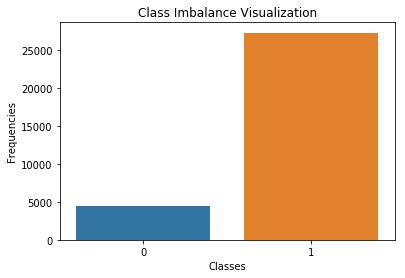

In [7]:
import seaborn as sns

print(df_final.groupby('loan_status').size())

sns.countplot(x="loan_status", data=df_final)
plt.xlabel("Classes")
plt.ylabel("Frequencies")
plt.title("Class Imbalance Visualization")
plt.show()


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
lr = LogisticRegression()
lr.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [9]:
print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))

0.8605089538171536
0.8582256607626753


## Logistic Regression with balanced class weight.

This was done so both classes are equal when the models are run. Doing this resulted in lowering of the accuracy score but, the recall / precision of the minority class went up. 

This is important as there is more of a risk to predicting a default incorrectly rather than predicting paid in full incorrectly. 

In [10]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))


0.6891297518064718
0.6886462710599693


In [11]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.87      0.44       894
           1       0.97      0.66      0.78      5472

   micro avg       0.69      0.69      0.69      6366
   macro avg       0.63      0.76      0.61      6366
weighted avg       0.87      0.69      0.74      6366



## GridSearch on Balanced Weights: 

To see the best score, Grid Search with various weights were used and the best parameters was used to check the accuracy score.

Precision / recall is much balanced and the accuracy is higher based on GridSearch's class weights. 

### SMOTE oversampling was also done for Logistic Regression. 

Best parameters : {'class_weight': {0: 0.381578947368421, 1: 0.618421052631579}}


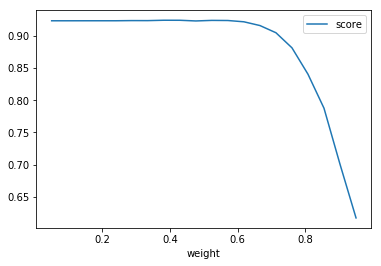

In [12]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [13]:
lr = LogisticRegression(**grid_result.best_params_)

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.04      0.07       894
           1       0.86      1.00      0.93      5472

   micro avg       0.86      0.86      0.86      6366
   macro avg       0.76      0.52      0.50      6366
weighted avg       0.83      0.86      0.81      6366



In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

pipe = make_pipeline(
    SMOTE(),
    LogisticRegression()
)

# Fit..
pipe.fit(X_train, y_train)

# Predict..
y_pred = pipe.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.86      0.45       894
           1       0.97      0.68      0.80      5472

   micro avg       0.70      0.70      0.70      6366
   macro avg       0.63      0.77      0.62      6366
weighted avg       0.87      0.70      0.75      6366



## Random Forest with balanced class weight.

This was done so both classes are equal when the models are run. Doing this resulted in similar accuracy scores as before and recall/ precision score for the minority class went up.

This is important as there is more of a risk to predicting a default incorrectly rather than predicting paid in full incorrectly. 

In [15]:
from sklearn.ensemble import RandomForestClassifier
w = .9
RF = RandomForestClassifier(class_weight='balanced')
RF.fit(X_train, y_train)
print(RF.score(X_train, y_train))

0.9944232808388642


In [16]:
y_pred = RF.predict(X_test)

In [17]:
print(RF.score(X_test, y_test))

0.8625510524662269


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.34      0.41       894
           1       0.90      0.95      0.92      5472

   micro avg       0.86      0.86      0.86      6366
   macro avg       0.71      0.65      0.67      6366
weighted avg       0.84      0.86      0.85      6366



## GridSearch on Balanced Weights: 

To see the best score, Grid Search with various weights were used and the best parameters was used to check the accuracy score.

Precision / recall is much balanced and the accuracy is higher based on GridSearch's class weights. 

### SMOTE oversampling was also done for Random Forest Classifier. 

Best parameters : {'class_weight': {0: 0.95, 1: 0.050000000000000044}}


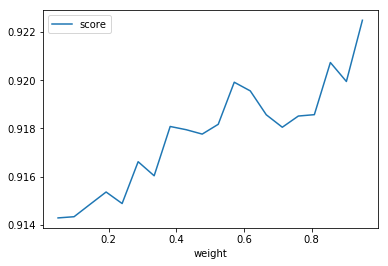

In [19]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [20]:
RF = RandomForestClassifier(**grid_result.best_params_)

# Fit..
RF.fit(X_train, y_train)

# Predict..
y_pred = RF.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.30      0.38       894
           1       0.89      0.95      0.92      5472

   micro avg       0.86      0.86      0.86      6366
   macro avg       0.69      0.63      0.65      6366
weighted avg       0.84      0.86      0.84      6366



In [21]:
print(RF.score(X_test, y_test))

0.8583097706566133


In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

pipe = make_pipeline(
    SMOTE(),
   RandomForestClassifier()
)

# Fit..
pipe.fit(X_train, y_train)

# Predict..
y_pred = pipe.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.42      0.42       894
           1       0.91      0.91      0.91      5472

   micro avg       0.84      0.84      0.84      6366
   macro avg       0.67      0.66      0.66      6366
weighted avg       0.84      0.84      0.84      6366



In [23]:
pipe.score(X_test, y_test)

0.8385171222117499

In [24]:
pipe.score(X_train, y_train)

0.9945018261791619